In [1]:
import state_utils

host = "am"
state_utils.set_host(host)
state_utils.set_midas_db_type("standard")
state_utils.set_cohort("Poyet")

#state_utils.set_cohort("")

'Poyet'

In [2]:
import numpy as np
import pandas as pd
import config
import sys
import parse_midas_data
import itertools

host = config.host
analysis_dir = config.analysis_directory
min_depth = config.min_depth_pi_site
frac_sites = config.min_prev_pi_site
postproc_idx_dic = config.postproc_idx_dic
good_species = parse_midas_data.parse_good_species_list()

## implement pi estimate from Schloissnig (2013)
def calculate_pi(species): 
    
    snps_dir = "%ssnps/%s" % (config.data_directory,species)
    snps_summary = pd.read_csv("%s/snps_summary.txt" % snps_dir,sep="\t",index_col=0)
    L = snps_summary["covered_bases"]
   
    chunk_size = 40000
    samples_host = list(pd.read_csv("%s/snps_depth.txt.bz2" % snps_dir,sep="\t",index_col=0, nrows=0))
    samples_tuples = list(itertools.combinations(samples_host, 2)) + [(s1,s1) for s1 in samples_host]
    
    pi_vals = pd.DataFrame(0,index=samples_host,columns=samples_host)
    df_depth_reader = pd.read_csv("%s/snps_depth.txt.bz2" % snps_dir,sep="\t",index_col=0, iterator=True,low_memory=False)
    df_refreq_reader = pd.read_csv("%s/snps_ref_freq.txt.bz2" % snps_dir,sep="\t",index_col=0, iterator=True,low_memory=False)

    df_depth = df_depth_reader.get_chunk(0)
    df_refreq = df_refreq_reader.get_chunk(0)

    reader=True
   
    num_samples = len(samples_host)
    pairwise_dic = {s:0 for s in samples_tuples}
    num_comps_dic = {s:0 for s in samples_tuples}
    i = 0
    while reader:
        i+=1
        
        perc_comp = (1.0*i*chunk_size)/(L.mean())
        
        df_depth = df_depth_reader.get_chunk(chunk_size)
        df_refreq = df_refreq_reader.get_chunk(chunk_size)

        if df_depth.shape[0] < chunk_size:
            reader=False
            sys.stderr.write("Complete")
        else:
            sys.stderr.write("%s percent complete \n" % perc_comp)
        df_refreq = df_refreq.mask(df_depth < min_depth)   

        df_refcount = df_depth*df_refreq
        df_refreq_2 = df_refcount/(df_depth - 1)
        df_refreq_2 = df_refreq_2.where(df_refreq_2 > .05,0)
        df_refreq_2 = df_refreq_2.where(df_refreq_2 < .95,1)

        df_altcount = df_depth*(1-df_refreq)
        df_altfreq = 1 - df_refreq
        df_altfreq_2 = df_altcount/(df_depth - 1)
        df_altreq_2 = df_altfreq_2.where(df_altfreq_2 > .05,0)
        df_altfreq_2 = df_altfreq_2.where(df_altfreq_2 < .95,1)


        for S in samples_tuples:
            
            s1 = S[0]
            s2 = S[1]
            s1s2 = (df_refreq[s1]*df_altfreq_2[s2] + df_refreq_2[s1]*df_altfreq[s2])

            pairwise_dic[(s1,s2)] += s1s2.sum()
            num_comps_dic[(s1,s2)] += s1s2.notna().sum()
    
    pi = {s:pairwise_dic[s]/num_comps_dic[s] for s in samples_tuples}
    
    pi_r = {(s[1],s[0]):pi[s] for s in samples_tuples}
    
    for s in pi_r.keys():
        pi[s] = pi_r[s]
    
    df = pd.Series(pi).unstack()
    
    dates = config.dates
    species_dates = dates[[d for d in dates.index if d in df.index]]
    
    df = df.loc[species_dates.index,species_dates.index]
    
    return pi, pairwise_dic, num_comps_dic

In [3]:
species = good_species[6]

In [4]:
species

'Eubacterium_rectale_56927'

In [5]:
pi, pairwise_dic, num_comps_dic = calculate_pi(species)

0.014983488885277516 percent complete 
0.029966977770555032 percent complete 
0.04495046665583255 percent complete 
0.059933955541110064 percent complete 
0.07491744442638758 percent complete 
0.0899009333116651 percent complete 
0.10488442219694262 percent complete 
0.11986791108222013 percent complete 
0.13485139996749765 percent complete 
0.14983488885277516 percent complete 
0.1648183777380527 percent complete 
0.1798018666233302 percent complete 
0.1947853555086077 percent complete 
0.20976884439388524 percent complete 
0.22475233327916275 percent complete 
0.23973582216444025 percent complete 
0.2547193110497178 percent complete 
0.2697027999349953 percent complete 
0.2846862888202728 percent complete 
0.2996697777055503 percent complete 
0.3146532665908279 percent complete 
0.3296367554761054 percent complete 
0.3446202443613829 percent complete 
0.3596037332466604 percent complete 
0.3745872221319379 percent complete 
0.3895707110172154 percent complete 
0.404554199902493 perce

In [6]:
df = pd.Series(pi).unstack()

In [7]:
df = df.where(df.notna(),0)

In [8]:
dates = config.dates
species_dates = dates[[d for d in dates.index if d in df.index]]

In [9]:
df = df.loc[species_dates.index,species_dates.index]

In [38]:
pi_w = pd.Series(np.diag(df), index=df.index)
#pi_bt0 = df

In [39]:
import matplotlib.pyplot as plt

In [10]:
num_comps_dic

{('1014.2', '1014.2'): 2628626,
 ('1014.2', '1021'): 2602382,
 ('1014.2', '1022'): 2486805,
 ('1014.2', '1023'): 2186130,
 ('1014.2', '4021A'): 2622230,
 ('1014.2', '4025.4'): 2591622,
 ('1014.2', '6037.2'): 2611309,
 ('1014.2', '6038.1'): 2585221,
 ('1014.2', '6041'): 2541967,
 ('1021', '1021'): 2631862,
 ('1021', '1022'): 2491320,
 ('1021', '1023'): 2187891,
 ('1021', '4021A'): 2617974,
 ('1021', '4025.4'): 2590246,
 ('1021', '6037.2'): 2615306,
 ('1021', '6038.1'): 2594232,
 ('1021', '6041'): 2529729,
 ('1022', '1022'): 2493141,
 ('1022', '1023'): 2170637,
 ('1022', '4021A'): 2490258,
 ('1022', '4025.4'): 2486660,
 ('1022', '6038.1'): 2484413,
 ('1022.1', '1014.2'): 2610952,
 ('1022.1', '1021'): 2617588,
 ('1022.1', '1022'): 2490588,
 ('1022.1', '1022.1'): 2648703,
 ('1022.1', '1023'): 2187784,
 ('1022.1', '4021.1A'): 2555796,
 ('1022.1', '4021A'): 2627950,
 ('1022.1', '4025.4'): 2597727,
 ('1022.1', '6037.2'): 2623771,
 ('1022.1', '6038.1'): 2595282,
 ('1022.1', '6041'): 2537912,
 

(0.0001, 0.01)

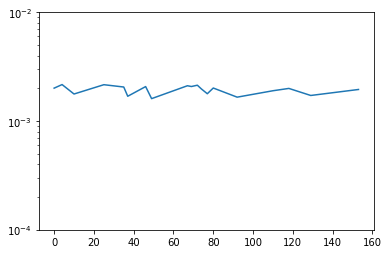

In [40]:
plt.plot(species_dates.values,pi_w.values)
plt.semilogy();
plt.ylim([1e-4,1e-2])


(0.0001, 0.01)

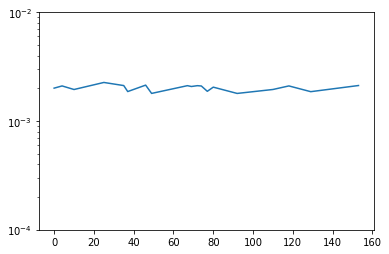

In [41]:
plt.plot(species_dates.values,df.iloc[0].values)
plt.semilogy();
plt.ylim([1e-4,1e-2])


In [40]:
snps_dir = "%ssnps/%s" % (config.data_directory,species)
snps_summary = pd.read_csv("%s/snps_summary.txt" % snps_dir,sep="\t",index_col=0)
L = snps_summary["covered_bases"]

chunk_size = 40000
samples_host = list(pd.read_csv("%s/snps_depth.txt.bz2" % snps_dir,sep="\t",index_col=0, nrows=0))
samples_tuples = list(itertools.combinations(samples_host, 2)) + [(s1,s1) for s1 in samples_host]

pi_vals = pd.DataFrame(0,index=samples_host,columns=samples_host)
df_depth_reader = pd.read_csv("%s/snps_depth.txt.bz2" % snps_dir,sep="\t",index_col=0, iterator=True,low_memory=False)
df_refreq_reader = pd.read_csv("%s/snps_ref_freq.txt.bz2" % snps_dir,sep="\t",index_col=0, iterator=True,low_memory=False)

df_depth = df_depth_reader.get_chunk(0)
df_refreq = df_refreq_reader.get_chunk(0)

reader=True

num_samples = len(samples_host)
pairwise_dic = {s:0 for s in samples_tuples}
num_comps_dic = {s:0 for s in samples_tuples}

i = 0
i+=1

perc_comp = (1.0*i*chunk_size)/(L.mean())

df_depth = df_depth_reader.get_chunk(chunk_size)
df_refreq = df_refreq_reader.get_chunk(chunk_size)

if df_depth.shape[0] < chunk_size:
    reader=False
    sys.stderr.write("Complete")
else:
    sys.stderr.write("%s percent complete \n" % perc_comp)

df_refreq = df_refreq.mask(df_depth < min_depth)   

df_refcount = df_depth*df_refreq
df_refreq_2 = df_refreq
#df_refreq_2 = df_refreq_2.where(df_refreq_2 > .05,0)
#df_refreq_2 = df_refreq_2.where(df_refreq_2 < .95,1)
df_refreq_2 = df_refreq_2.mask(df_depth < min_depth)   


df_altcount = df_depth*(1-df_refreq)
df_altfreq = 1 - df_refreq
df_altfreq_2 = df_altfreq
#df_altreq_2 = df_altfreq_2.where(df_altfreq_2 > .05,0)
#df_altfreq_2 = df_altfreq_2.where(df_altfreq_2 < .95,1)
df_altreq_2 = df_altreq_2.mask(df_depth < min_depth)   


0.014983488885277516 percent complete 


In [41]:
for S in samples_tuples:

    s1 = S[0]
    s2 = S[1]
    s1s2 = (df_refreq[s1]*df_altfreq_2[s2] + df_refreq_2[s1]*df_altfreq[s2])

    pairwise_dic[(s1,s2)] += s1s2.sum()
    num_comps_dic[(s1,s2)] += s1s2.notna().sum()

pi = {s:pairwise_dic[s]/num_comps_dic[s] for s in samples_tuples}

pi_r = {(s[1],s[0]):pi[s] for s in samples_tuples}

for s in pi_r.keys():
    pi[s] = pi_r[s]

df = pd.Series(pi).unstack()

dates = config.dates
species_dates = dates[[d for d in dates.index if d in df.index]]

df = df.loc[species_dates.index,species_dates.index]

In [42]:
pairwise_dic[("4026.2","6037")]/num_comps_dic[("4026.2","6037")]

0.0018323424338779787

In [43]:
df_refreq

,4026.2,6037,4026,6037.3,4022,4023,4024.1,1025,1022.1,4021.1A,1014.2,1021,6041,6037.2,1022,1023,6038.1,4025.4,4021A
site_id,,,,,,,,,,,,,,,,,,,
FP929042|1|T,NaN,NaN,1.000000,NaN,NaN,0.983333,NaN,1.000000,1.000000,NaN,1.000000,NaN,1.000000,0.928571,NaN,NaN,1.000000,1.000000,0.951220
FP929042|2|G,NaN,0.625000,0.909091,NaN,0.666667,0.820755,NaN,0.848485,0.833333,NaN,0.681818,0.875000,0.714286,0.863636,NaN,NaN,0.500000,0.875000,0.666667
FP929042|3|A,0.714286,0.777778,1.000000,NaN,0.900000,0.860140,1.000000,0.884615,0.866667,0.750000,0.833333,0.916667,0.857143,0.948718,1.000,NaN,0.666667,0.846154,0.813008
FP929042|4|A,0.750000,0.818182,0.882353,NaN,0.812500,0.774359,0.909091,0.800000,0.782609,0.555556,0.789474,0.700000,0.650000,0.916667,0.875,NaN,0.625000,0.705882,0.701754
FP929042|5|T,1.000000,1.000000,0.976744,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,NaN,1.000000,1.000000,1.000000
FP929042|6|G,1.000000,1.000000,0.976190,NaN,1.000000,0.975207,1.000000,0.987805,0.964286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,NaN,0.947368,0.965517,1.000000
FP929042|7|A,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,0.964286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,NaN,1.000000,1.000000,1.000000
FP929042|8|A,1.000000,1.000000,0.981132,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,NaN,1.000000,1.000000,1.000000
FP929042|9|C,1.000000,1.000000,0.984127,1.0,1.000000,1.000000,1.000000,1.000000,0.967742,1.000000,1.000000,1.000000,1.000000,1.000000,1.000,NaN,1.000000,1.000000,1.000000
